In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2023-06-25 11:01:54--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2023-06-25 11:01:54 (7.91 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [3]:
!head /tmp/daily-min-temperatures.csv

"Date","Temp"
"1981-01-01",20.7
"1981-01-02",17.9
"1981-01-03",18.8
"1981-01-04",14.6
"1981-01-05",15.8
"1981-01-06",15.8
"1981-01-07",15.8
"1981-01-08",17.4
"1981-01-09",21.8


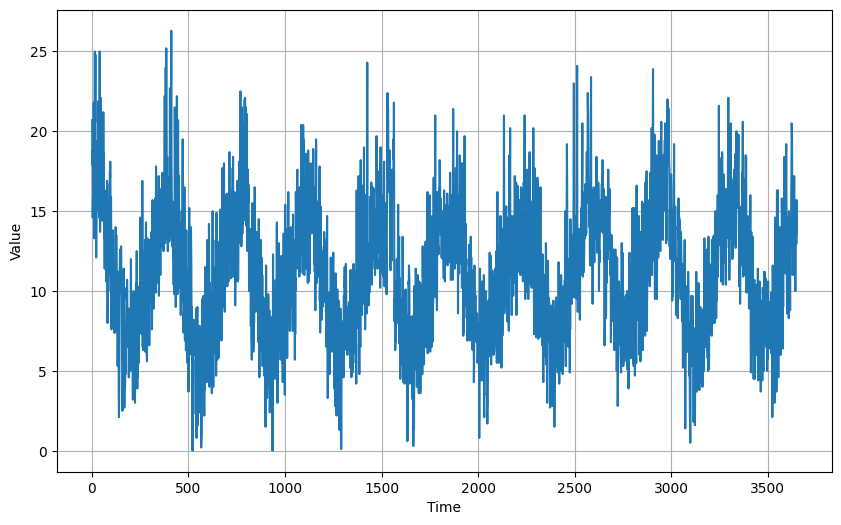

In [4]:
from os import read
import csv
time_step = []
temps = []
step=1
with open('/tmp/daily-min-temperatures.csv') as csvfile:
  # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader=csv.reader(csvfile,delimiter=',')
  next(reader)

  for row in reader:
    time_step.append(step)
    step+=1
    temps.append(float(row[1]))

series=np.array(temps)
time=np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1)
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size+1,shift=1,drop_remainder=True)
  ds=ds.flat_map(lambda window: window.batch(window_size+1))
  ds=ds.map(lambda w: (w[:-1],w[-1]))
  ds=ds.shuffle(shuffle_buffer)

  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model,series,window_size):
  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size,shift=1,drop_remainder=True)
  ds=ds.flat_map(lambda w: w.batch(window_size))
  ds=ds.batch(32).prefetch(1)
  forecast=model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
(2500,)


In [10]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=5,padding="causal",
                           strides=1,input_shape=[None,1],activation="relu"),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Dense(30,activation="relu"),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400.0)

])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD( momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 14s 49ms/step - loss: 138.5466 - mae: 139.0466 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 30ms/step - loss: 137.3323 - mae: 137.8323 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 39ms/step - loss: 135.4785 - mae: 135.9785 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 133.2350 - mae: 133.7350 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 35ms/step - loss: 130.6683 - mae: 131.1683 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 33ms/step - loss: 127.7769 - mae: 128.2769 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 34ms/step - loss: 124.5358 - mae: 125.0358 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 35ms/step - loss: 120.8966 - mae: 121.3966 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 1s 34ms/step - los

(1e-08, 0.0001, 0.0, 60.0)

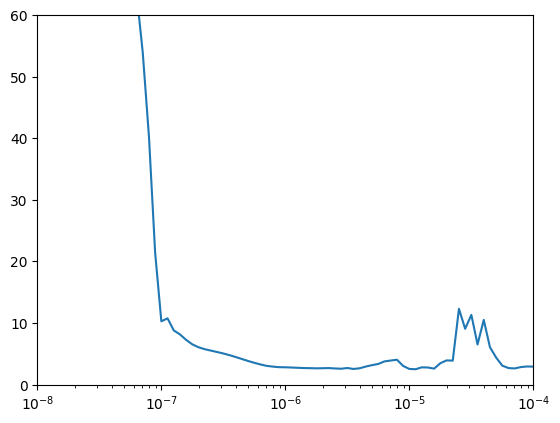

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 80
batch_size = 100
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=5,padding="causal",
                           strides=1,input_shape=[None,1],activation="relu"),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64),

    tf.keras.layers.Dense(30,activation="relu"),
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400.0)

])
lr=3e-6
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50)

# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 4s 22ms/step - loss: 4.4783 - mae: 4.9574
Epoch 2/50
25/25 [==============================] - 1s 21ms/step - loss: 3.2202 - mae: 3.6961
Epoch 3/50
25/25 [==============================] - 1s 17ms/step - loss: 2.3684 - mae: 2.8316
Epoch 4/50
25/25 [==============================] - 1s 18ms/step - loss: 2.2146 - mae: 2.6720
Epoch 5/50
25/25 [==============================] - 1s 34ms/step - loss: 2.0138 - mae: 2.4695
Epoch 6/50
25/25 [==============================] - 1s 36ms/step - loss: 1.9759 - mae: 2.4322
Epoch 7/50
25/25 [==============================] - 1s 18ms/step - loss: 1.8580 - mae: 2.3107
Epoch 8/50
25/25 [==============================] - 1s 18ms/step - loss: 1.9168 - mae: 2.3748
Epoch 9/50
25/25 [==============================] - 1s 18ms/step - loss: 1.8713 - mae: 2.3224
Epoch 10/50
25/25 [==============================] - 1s 18ms/step - loss: 1.8921 - mae: 2.3479
Epoch 11/50
25/25 [==============================] - 1s 20m

In [49]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]

112/112 [==============================] - 2s 8ms/step


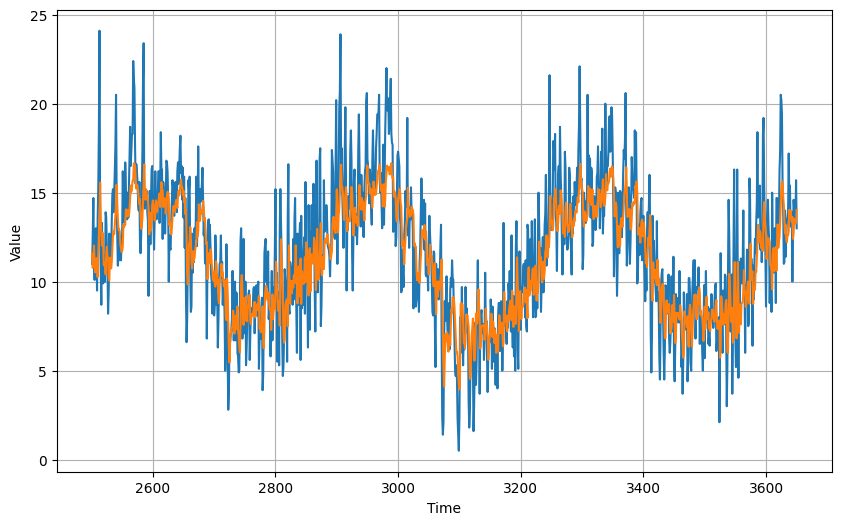

In [50]:

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.9077635

In [40]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.829656 11.679857 12.058299 ... 13.639969 13.703537 14.687193]
